In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install yfinance

In [3]:
import yfinance as yf

In [4]:
ms = yf.download('GOOG',
            start="2013-01-01",
            end="2023-09-30",
            progress=False)
df = ms[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df.head(10)

,Adj Close,Open,Close,High,Low
Date,,,,,
2013-01-02,18.014,17.918,18.014,18.107,17.847
2013-01-03,18.024,18.056,18.024,18.230,17.951
2013-01-04,18.380,18.165,18.380,18.468,18.124
2013-01-07,18.300,18.318,18.300,18.415,18.196
2013-01-08,18.264,18.320,18.264,18.339,18.043
2013-01-09,18.384,18.238,18.384,18.390,18.147
2013-01-10,18.468,18.501,18.468,18.555,18.269
2013-01-11,18.431,18.481,18.431,18.491,18.339
2013-01-14,18.014,18.356,18.014,18.486,17.991


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
from keras.layers import LSTM






# GluonTS

In [5]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:00


In [6]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [7]:
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
df

,Adj Close,Open,Close,High,Low
Date,,,,,
2013-01-02,18.014,17.918,18.014,18.107,17.847
2013-01-03,18.024,18.056,18.024,18.230,17.951
2013-01-04,18.380,18.165,18.380,18.468,18.124
2013-01-07,18.300,18.318,18.300,18.415,18.196
2013-01-08,18.264,18.320,18.264,18.339,18.043
...,...,...,...,...,...
2023-09-25,132.170,130.770,132.170,132.220,130.030
2023-09-26,129.450,130.914,129.450,131.405,128.190
2023-09-27,131.460,129.440,131.460,131.720,129.380


In [9]:
train_data = ListDataset(
    [{"start":df.index[0], "target":df.Close[:"2020"]}],
    freq="D"
)

<Axes: >

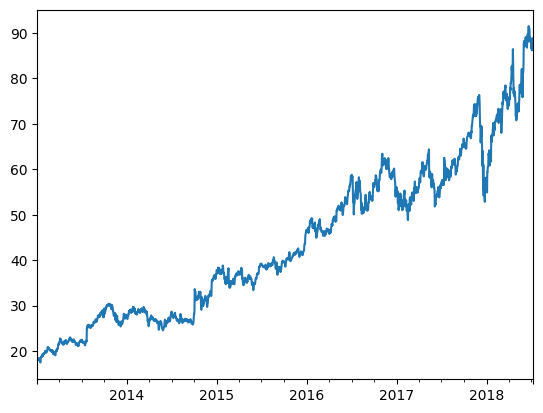

In [10]:
train_listData = next(iter(train_data))
train_series = to_pandas(train_listData)
train_series.plot()

In [11]:
test_data = ListDataset(
    [{"start":df.index[0], "target":df.Close}],
    freq="D"
)

<Axes: >

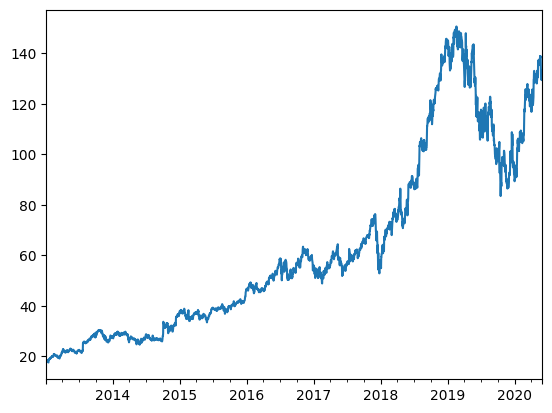

In [12]:
test_listData = next(iter(test_data))
test_series = to_pandas(test_listData)
test_series.plot()

In [13]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestMean
from gluonts.mx.trainer import Trainer

In [14]:
callbacks = [
      LearningRateReduction(objective="min",
                            patience=10,
                            base_lr=1e-3,
                            decay_factor=0.5),
      ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

In [29]:
deepAR_model = DeepAREstimator(
    freq="D",
    prediction_length=10,
    context_length=20,
    num_layers=4,
    num_cells=100,
    dropout_rate=0.05,
    trainer=Trainer(epochs=30, callbacks=callbacks)
)

In [30]:
deepAR_model_predictator = deepAR_model.train(train_data)

100%|██████████| 50/50 [00:07<00:00,  6.35it/s, epoch=30/30, avg_epoch_loss=0.946]


In [40]:
from gluonts.evaluation import make_evaluation_predictions

In [41]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=deepAR_model_predictator,
    num_samples=100,
)

In [42]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [43]:
ts_entry = tss[0]

In [47]:
forecast_entry = forecasts[0]

In [48]:
forecast_entry.samples.shape

(100, 10)

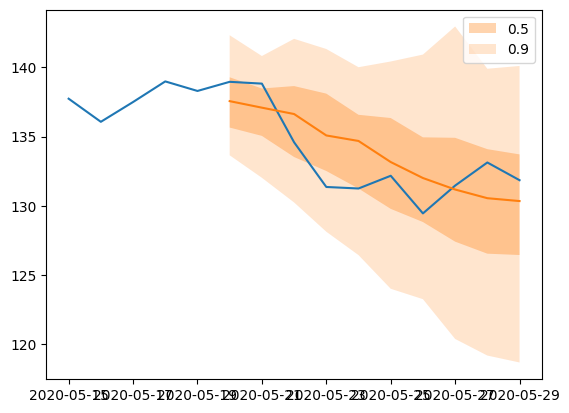

In [50]:
plt.plot(ts_entry[-15:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()